In [134]:
import os
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [135]:
patient = 1

In [136]:
# Load the two NIfTI images
T1_path = f'data/{patient}/T1.nii'
T2_path = f'data/{patient}/T2_FLAIR.nii'
label_path = f'data/{patient}/LabelsForTesting.nii'
relative_save_path = f'results/singlemodal_s/{patient}/'


### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [137]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.expand_dims(T1_skull_stripped, axis=1)

## EM Algorithm

In [138]:
## Min Max scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

X = scaler.fit_transform(X)

Iteration:  0  --- Log Likelihood:  11.726544157135825  --- Time (s):  0.04293203353881836


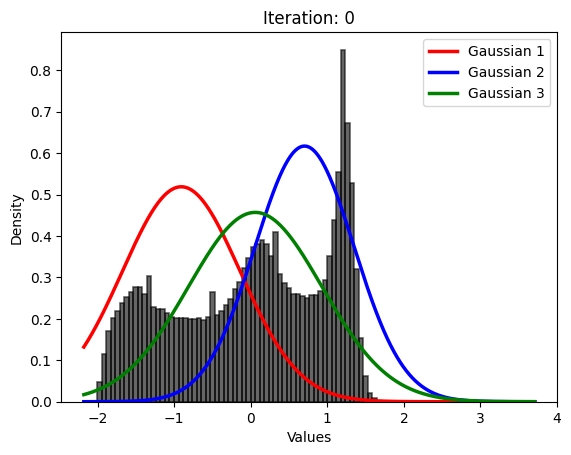

Iteration:  1  --- Log Likelihood:  11.737091688271681  --- Time (s):  0.03780698776245117
Iteration:  2  --- Log Likelihood:  11.74505735894932  --- Time (s):  0.04199790954589844
Iteration:  3  --- Log Likelihood:  11.75151198018038  --- Time (s):  0.05790519714355469
Iteration:  4  --- Log Likelihood:  11.75667515332206  --- Time (s):  0.05124211311340332
Iteration:  5  --- Log Likelihood:  11.760891392757848  --- Time (s):  0.049278974533081055
Iteration:  6  --- Log Likelihood:  11.764681613389461  --- Time (s):  0.05088210105895996
Iteration:  7  --- Log Likelihood:  11.768569159947782  --- Time (s):  0.08850479125976562
Iteration:  8  --- Log Likelihood:  11.7730657590086  --- Time (s):  0.04346323013305664
Iteration:  9  --- Log Likelihood:  11.778736224275073  --- Time (s):  0.043383121490478516
Iteration:  10  --- Log Likelihood:  11.786256419846913  --- Time (s):  0.04811286926269531
Iteration:  11  --- Log Likelihood:  11.796390450043544  --- Time (s):  0.0507969856262207
I

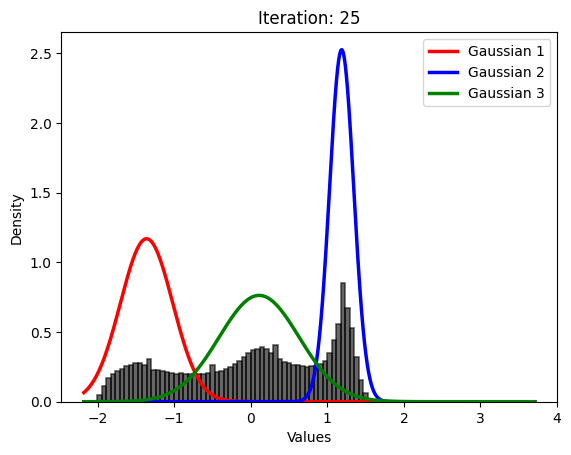

Iteration:  26  --- Log Likelihood:  11.920504013202931  --- Time (s):  0.047328948974609375
Iteration:  27  --- Log Likelihood:  11.921572546745843  --- Time (s):  0.04776191711425781
Iteration:  28  --- Log Likelihood:  11.922401891964448  --- Time (s):  0.042756080627441406
Iteration:  29  --- Log Likelihood:  11.923044665166021  --- Time (s):  0.043061017990112305
Iteration:  30  --- Log Likelihood:  11.923542838002314  --- Time (s):  0.04176902770996094
Iteration:  31  --- Log Likelihood:  11.923929390900945  --- Time (s):  0.04692411422729492
Iteration:  32  --- Log Likelihood:  11.924229944436888  --- Time (s):  0.03983283042907715
Iteration:  33  --- Log Likelihood:  11.924464238147149  --- Time (s):  0.04291725158691406
Iteration:  34  --- Log Likelihood:  11.924647397814637  --- Time (s):  0.039285898208618164
Iteration:  35  --- Log Likelihood:  11.924790979295244  --- Time (s):  0.039939165115356445
Iteration:  36  --- Log Likelihood:  11.924903803814795  --- Time (s):  0.0

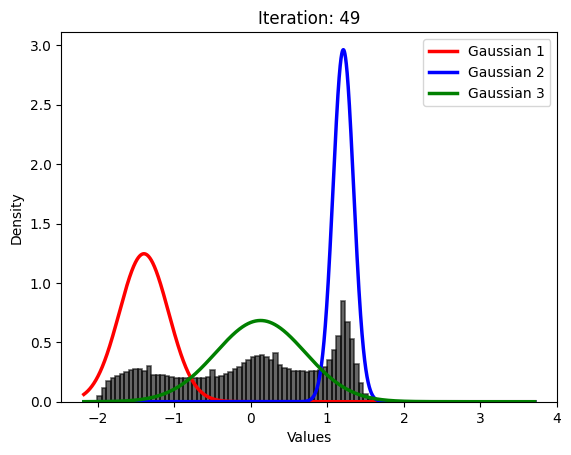

In [139]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=50, type='kmeans', plot_step=25, save_path=relative_save_path, show_plot=True, stop_criterion=1e-6)
alphas, mus, covars, W = em.fit()

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [140]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [141]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == sorted_mean_indices[0])
class2_idx = np.where(segmented_image == sorted_mean_indices[1])
class3_idx = np.where(segmented_image == sorted_mean_indices[2])
segmented_image[class1_idx] = 1
segmented_image[class2_idx] = 2
segmented_image[class3_idx] = 3

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))

print("Segmented brain image saved as " + os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))

Segmented brain image saved as results/singlemodal_s/1/segmented_brain_1.nii


## Evaluation

In [142]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, os.path.join(relative_save_path, f'segmented_brain_{patient}.nii'))    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.793930868021098, 2: 0.7773567300223594, 3: 0.8573641299722558}
Average Dice Score:  0.8095505760052376


## Visualization

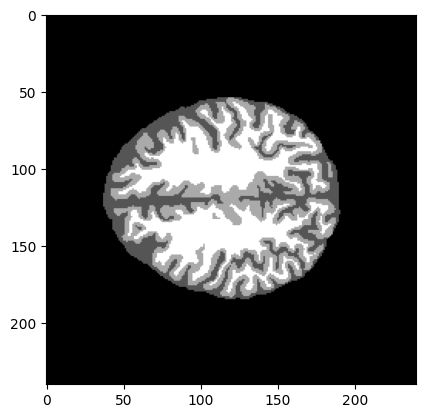

In [143]:
import matplotlib.pyplot as plt
plt.imshow(labels_np_img[:,:, 30], cmap='gray')
plt.show()

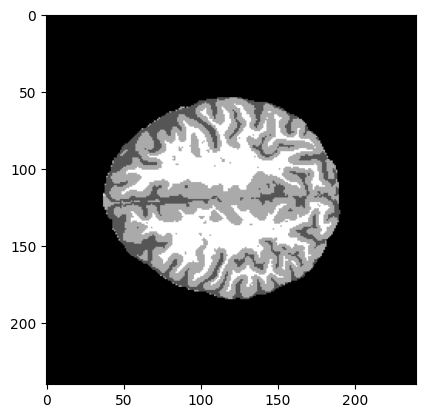

In [144]:
import matplotlib.pyplot as plt
plt.imshow(segmented_image[:,:, 30], cmap='gray')
plt.show()